<a href="https://colab.research.google.com/github/mae25-create/data_visualization-analysis_practice/blob/main/Expedia_kNN_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Applying kNN and Decision Trees to the Expedia Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_clean = pd.read_csv("expedia_clean.csv")

We are going to create ML models to predict, based on the information from the search of a client, if they will end up buying or not. To do so, we'll use ``df_clean``, that only considers "normal" searches, i.e., searches for future events (search lead time bigger than zero) and searches where the stay length is greater than zero.

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96534 entries, 0 to 96533
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0.1              96534 non-null  int64 
 1   Unnamed: 0                96534 non-null  int64 
 2   date_time                 96534 non-null  object
 3   site_name                 96534 non-null  int64 
 4   posa_continent            96534 non-null  int64 
 5   user_location_country     96534 non-null  object
 6   user_location_region      96534 non-null  int64 
 7   user_location_city        96534 non-null  int64 
 8   user_id                   96534 non-null  int64 
 9   is_mobile                 96534 non-null  int64 
 10  is_package                96534 non-null  int64 
 11  channel                   96534 non-null  int64 
 12  srch_ci                   96534 non-null  object
 13  srch_co                   96534 non-null  object
 14  srch_adults_cnt       

## Data Preparation

In [ ]:
# Converting the dates to date format (as it was in object format)

df_clean["date_time"] = pd.to_datetime(df_clean["date_time"])
df_clean["srch_ci"] = pd.to_datetime(df_clean["srch_ci"])
df_clean["srch_co"] = pd.to_datetime(df_clean["srch_co"])

In [ ]:
df_clean.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96534 entries, 0 to 96533
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date_time                 96534 non-null  datetime64[ns]
 1   site_name                 96534 non-null  int64         
 2   posa_continent            96534 non-null  int64         
 3   user_location_country     96534 non-null  object        
 4   user_location_region      96534 non-null  int64         
 5   user_location_city        96534 non-null  int64         
 6   user_id                   96534 non-null  int64         
 7   is_mobile                 96534 non-null  int64         
 8   is_package                96534 non-null  int64         
 9   channel                   96534 non-null  int64         
 10  srch_ci                   96534 non-null  datetime64[ns]
 11  srch_co                   96534 non-null  datetime64[ns]
 12  srch_adults_cnt   

Something important to consider here is that the data has a date. So, if we use the normal random cross validation, we'd be using future data to explain what happened in the past, which doesn't make sense.

The model might be trained on December 2014 searches and tested on February 2014 searches. So it's learning from future behavior to predict the past. In real life, this is impossible: we never have access to the future when making predictions.

We are going to start ignoring the date, so we can show you how to implement cross validation. But remember that, when there are dates, we need to be careful.

# kNN Model Implementation

In [ ]:
df_cv = df_clean.copy()

# Extract features/different columns from srch_ci (Check-in Date/orginal date)
df_cv["srch_ci_month"] = df_cv["srch_ci"].dt.month
df_cv["srch_ci_day"] = df_cv["srch_ci"].dt.day
df_cv["srch_ci_dow"] = df_cv["srch_ci"].dt.dayofweek  # Monday=0, Sunday=6
df_cv["srch_ci_hour"] = df_cv["srch_ci"].dt.hour

# Extract features from srch_co (Check-out Date)
df_cv["srch_co_month"] = df_cv["srch_co"].dt.month
df_cv["srch_co_day"] = df_cv["srch_co"].dt.day
df_cv["srch_co_dow"] = df_cv["srch_co"].dt.dayofweek
df_cv["srch_co_hour"] = df_cv["srch_co"].dt.hour

# Delete time objects
df_cv = df_cv.drop(columns=["srch_ci", "srch_co", "date_time", "time"])

In [ ]:
df_cv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96534 entries, 0 to 96533
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   site_name                 96534 non-null  int64 
 1   posa_continent            96534 non-null  int64 
 2   user_location_country     96534 non-null  object
 3   user_location_region      96534 non-null  int64 
 4   user_location_city        96534 non-null  int64 
 5   user_id                   96534 non-null  int64 
 6   is_mobile                 96534 non-null  int64 
 7   is_package                96534 non-null  int64 
 8   channel                   96534 non-null  int64 
 9   srch_adults_cnt           96534 non-null  int64 
 10  srch_children_cnt         96534 non-null  int64 
 11  srch_rm_cnt               96534 non-null  int64 
 12  srch_destination_id       96534 non-null  int64 
 13  srch_destination_type_id  96534 non-null  int64 
 14  is_booking            

In [ ]:
# Dealing with categorical variables by grouping them
# for kNN, we should do it because we only care about 2 columns
# for decision trees, we don't need to do to aviod slowing the run speed

day_map = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3,
    "Friday": 4, "Saturday": 5, "Sunday": 6
}
df_cv["day_of_week"] = df_cv["day_of_week"].map(day_map)

categorical_cols = ["user_location_country", "hotel_country"]

df_cv = pd.get_dummies(df_cv, columns=categorical_cols, prefix=categorical_cols, drop_first=True)

In [ ]:
X = df_cv.drop(["is_booking"], axis=1) # Define the explanatory variables
y = df_cv["is_booking"] # Define the target variable

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# Remember that we need to scale/ normalize the data

from sklearn.preprocessing import MinMaxScaler # You can also use standard scaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [ ]:
# Important: check the class imbalance to pick the right metric
# not to maximize accuracy, since it's imbalanced as the following result shows

df_cv['is_booking'].value_counts()

,count
is_booking,
0,89114
1,7420


In [ ]:
# WARNING: it takes 47 mins for kNN to run, be careful!
# for assignment: only take 1 out of 3 to test if there's error, then run the whole during night

# Define model
knn = KNeighborsClassifier()

# Define hyperparameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'metric': ['euclidean', 'manhattan']
}

# Set up StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Run GridSearchCV
# here choose 'recall' because of business goal: maximize recall can see actual bookings
# remember to adjust here for other cases
grid_knn = GridSearchCV(knn, param_grid_knn, cv=skf, scoring='recall', n_jobs=-1)
grid_knn.fit(X_train_scaled, y_train)

# Best results
print("Best kNN params:", grid_knn.best_params_)
print("Best CV score:", grid_knn.best_score_)

Best kNN params: {'metric': 'euclidean', 'n_neighbors': 3}
Best CV score: 0.030207540896770524


kNN is less favorable than decision trees if number of features is large, because kNN suffers more from the curse of dimensionality.

# Decision Trees

In [ ]:
# We are going to change the one hot encoding to a label encoder. It'll be faster

df_cv = df_clean.copy()

# Extract features from srch_ci (Check-in Date)
df_cv["srch_ci_month"] = df_cv["srch_ci"].dt.month
df_cv["srch_ci_day"] = df_cv["srch_ci"].dt.day
df_cv["srch_ci_dow"] = df_cv["srch_ci"].dt.dayofweek  # Monday=0, Sunday=6
df_cv["srch_ci_hour"] = df_cv["srch_ci"].dt.hour

# Extract features from srch_co (Check-out Date)
df_cv["srch_co_month"] = df_cv["srch_co"].dt.month
df_cv["srch_co_day"] = df_cv["srch_co"].dt.day
df_cv["srch_co_dow"] = df_cv["srch_co"].dt.dayofweek
df_cv["srch_co_hour"] = df_cv["srch_co"].dt.hour

# Delete time objects
df_cv = df_cv.drop(columns=["srch_ci", "srch_co", "date_time", "time"])

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Dealing with categorical variables

day_map = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3,
    "Friday": 4, "Saturday": 5, "Sunday": 6
}
df_cv["day_of_week"] = df_cv["day_of_week"].map(day_map)

categorical_cols = ["user_location_country", "hotel_country"]

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_cv[col] = le.fit_transform(df_cv[col])
    label_encoders[col] = le  # Save encoder if you want to inverse transform later

In [ ]:
X = df_cv.drop(["is_booking"], axis=1) # Define the explanatory variables
y = df_cv["is_booking"] # Define the target variable

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create and train the decision tree classifier
clf = DecisionTreeClassifier() # We don't set parameters. The tree will grow until the end.
clf.fit(X_train, y_train)

# Make predictions
y_train_pred_dt = clf.predict(X_train)
y_test_pred_dt = clf.predict(X_test)

# Calculate metrics
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)
train_precision_dt = precision_score(y_train, y_train_pred_dt)
test_precision_dt = precision_score(y_test, y_test_pred_dt)
train_recall_dt = recall_score(y_train, y_train_pred_dt)
test_recall_dt = recall_score(y_test, y_test_pred_dt)

# Print results
print("Training Set Metrics:")
print(f"Accuracy: {train_accuracy_dt:.4f}")
print(f"Precision: {train_precision_dt:.4f}")
print(f"Recall: {train_recall_dt:.4f}")

print("\nTesting Set Metrics:")
print(f"Accuracy: {test_accuracy_dt:.4f}")
print(f"Precision: {test_precision_dt:.4f}")
print(f"Recall: {test_recall_dt:.4f}")

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_dt).ravel()
print(confusion_matrix(y_test, y_test_pred_dt))

# Calculate false negative rate
fnr_dt = fn / (fn + tp)
print(f'False Negative Rate (FNR): {fnr_dt:.4f}')

Training Set Metrics:
Accuracy: 0.9999
Precision: 1.0000
Recall: 0.9988

Testing Set Metrics:
Accuracy: 0.8558
Precision: 0.1239
Recall: 0.1492
[[16304  1542]
 [ 1243   218]]
False Negative Rate (FNR): 0.8508


## Insights
1. accuracy is good, but we can't rely on accuracy

2. but, precision is low, which means the model is overfitting

3. so, we have to create a list of possible combination

[Text(0.7367791915773357, 0.9878048780487805, 'cnt <= 1.5\ngini = 0.142\nsamples = 77227\nvalue = [71268, 5959]\nclass = Not Booked'),
 Text(0.4873224005233003, 0.9634146341463414, 'stay_length <= 2.5\ngini = 0.184\nsamples = 57330\nvalue = [51443, 5887]\nclass = Not Booked'),
 Text(0.612050796050318, 0.975609756097561, 'True  '),
 Text(0.24902417757520867, 0.9390243902439024, 'srch_adults_cnt <= 1.5\ngini = 0.238\nsamples = 27129\nvalue = [23382, 3747]\nclass = Not Booked'),
 Text(0.10641655874881212, 0.9146341463414634, 'search_lead_time <= 18.5\ngini = 0.302\nsamples = 6701\nvalue = [5459, 1242]\nclass = Not Booked'),
 Text(0.05600037409479636, 0.8902439024390244, 'year <= 2013.5\ngini = 0.343\nsamples = 4075\nvalue = [3178, 897]\nclass = Not Booked'),
 Text(0.009494401187991651, 0.8658536585365854, 'user_location_country <= 14.5\ngini = 0.392\nsamples = 1234\nvalue = [904.0, 330.0]\nclass = Not Booked'),
 Text(0.0005553795889323261, 0.8414634146341463, 'hotel_market <= 16.0\ngini =

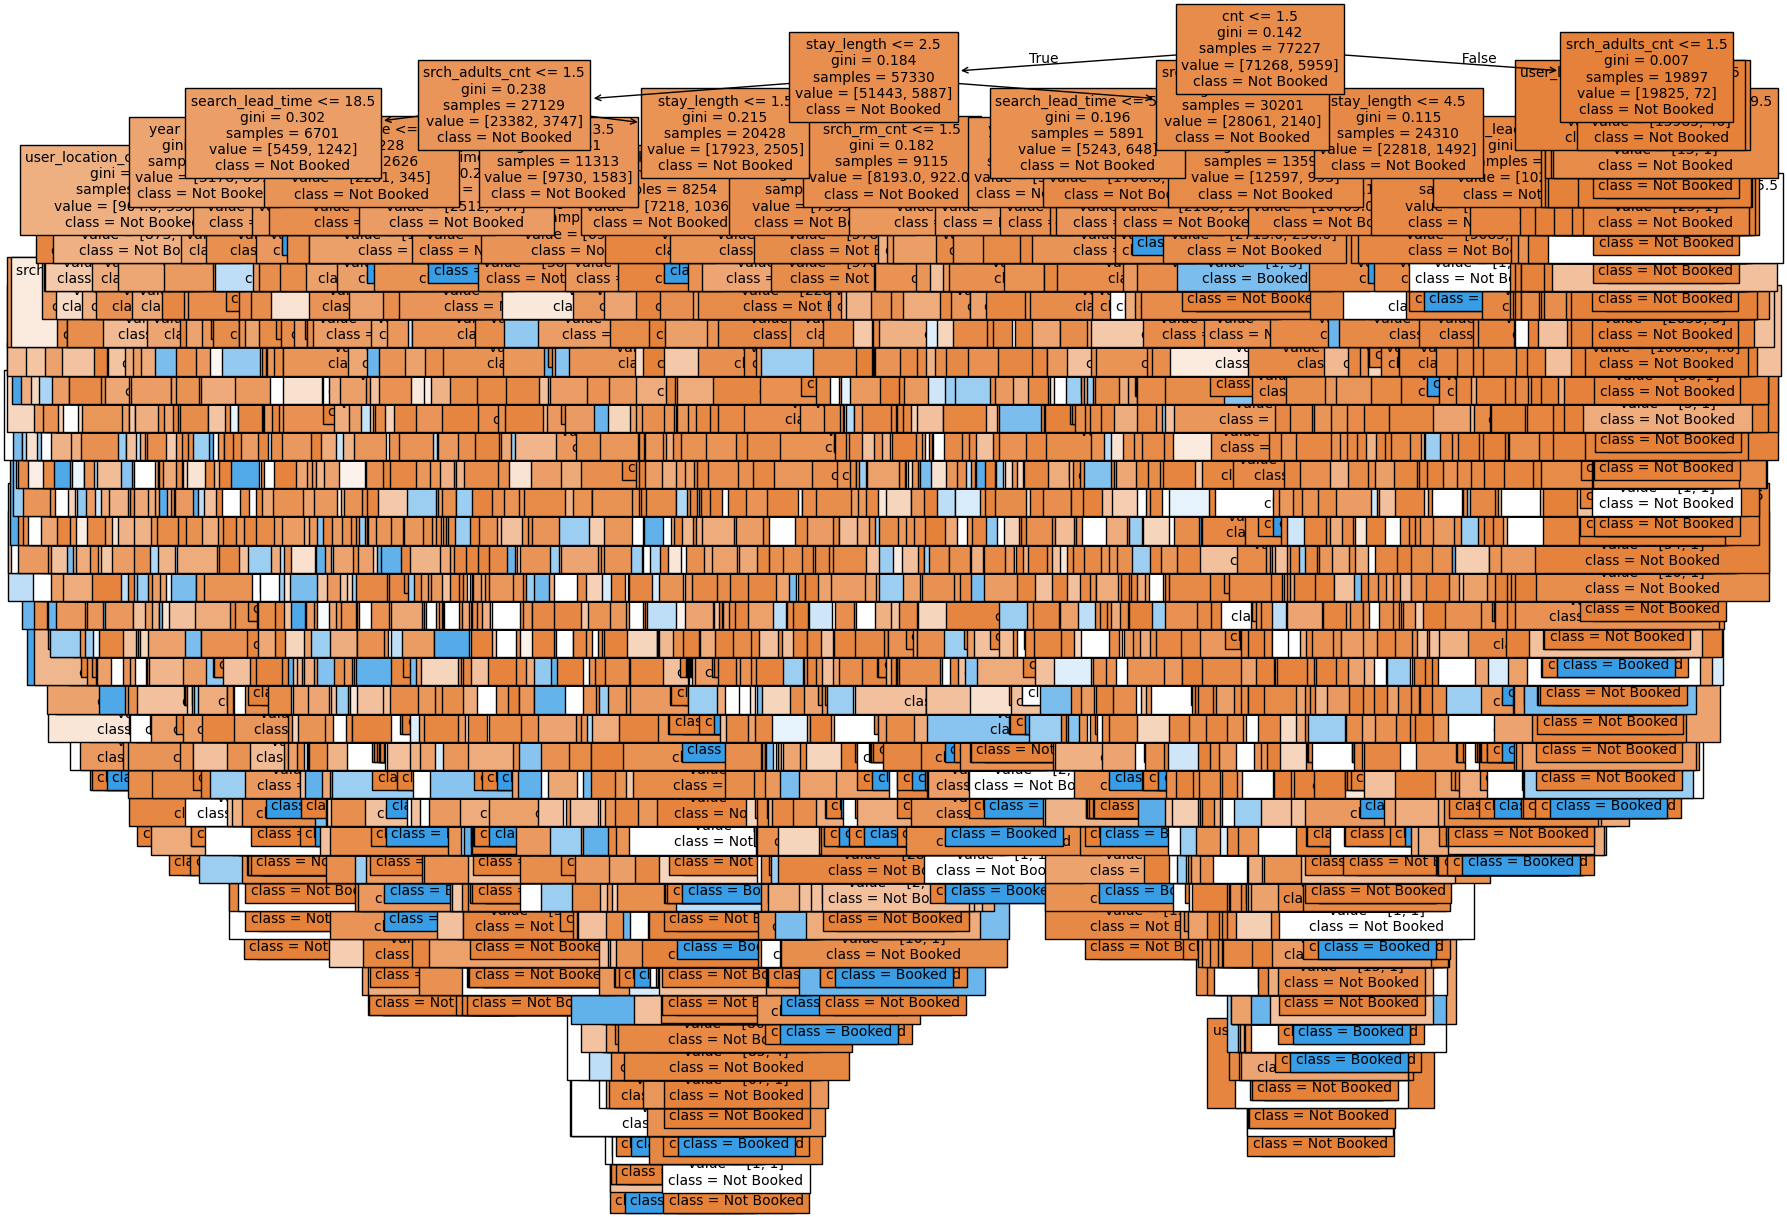

In [ ]:
# We plot the tree that we created.
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 15))
plot_tree(clf, feature_names = list(X.columns), fontsize=10, filled = True, class_names = ['Not Booked', 'Booked'])

In [ ]:
# WARNING: this chunk takes around 15 minutes to run.

tree = DecisionTreeClassifier()

tree_params = [{
    'max_depth': list(range(4, 10)),
    # 'max_depth': list(range(4, 6)),
    'criterion': ['gini', 'entropy'],
    # 'min_samples_split': list(range(10, 14, 5)),
    'min_samples_split': list(range(10, 25, 5)),
    # 'min_samples_leaf': list(range(5, 7, 5)),
    'min_samples_leaf': list(range(5, 25, 5)),
    'class_weight': [None, 'balanced']  # This adjusts the class imbalance
}]

clf = GridSearchCV(tree, tree_params, cv = 5, scoring='recall') # Remember to pick the right metric here. It's key!

clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'class_weight': [None, 'balanced'],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [4, 5, 6, 7, 8, 9],
                          'min_samples_leaf': [5, 10, 15, 20],
                          'min_samples_split': [10, 15, 20]}],
             scoring='recall')

In [ ]:
# Convert cv_results_ to a DataFrame for easy access
results = pd.DataFrame(clf.cv_results_)

# Print mean and std of recall for the best params
mean_score = results.loc[clf.best_index_, 'mean_test_score']
std_score = results.loc[clf.best_index_, 'std_test_score']

print("Best parameters found:", clf.best_params_)
print("Best recall score: {:.4f} ± {:.4f}".format(mean_score, std_score))

Best parameters found: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best recall score: 0.7934 ± 0.0509


[Text(0.5683962264150944, 0.9166666666666666, 'cnt <= 1.5\nentropy = 1.0\nsamples = 77227\nvalue = [38613.5, 38613.5]\nclass = Booked'),
 Text(0.3018867924528302, 0.75, 'stay_length <= 2.5\nentropy = 0.982\nsamples = 57330\nvalue = [27872.177, 38146.95]\nclass = Booked'),
 Text(0.43514150943396224, 0.8333333333333333, 'True  '),
 Text(0.1509433962264151, 0.5833333333333334, 'srch_adults_cnt <= 1.5\nentropy = 0.928\nsamples = 27129\nvalue = [12668.531, 24280.044]\nclass = Booked'),
 Text(0.07547169811320754, 0.4166666666666667, 'search_lead_time <= 18.5\nentropy = 0.84\nsamples = 6701\nvalue = [2957.724, 8047.989]\nclass = Booked'),
 Text(0.03773584905660377, 0.25, 'year <= 2013.5\nentropy = 0.775\nsamples = 4075\nvalue = [1721.863, 5812.437]\nclass = Booked'),
 Text(0.018867924528301886, 0.08333333333333333, 'entropy = 0.694\nsamples = 1234\nvalue = [489.794, 2138.355]\nclass = Booked'),
 Text(0.05660377358490566, 0.08333333333333333, 'entropy = 0.813\nsamples = 2841\nvalue = [1232.069

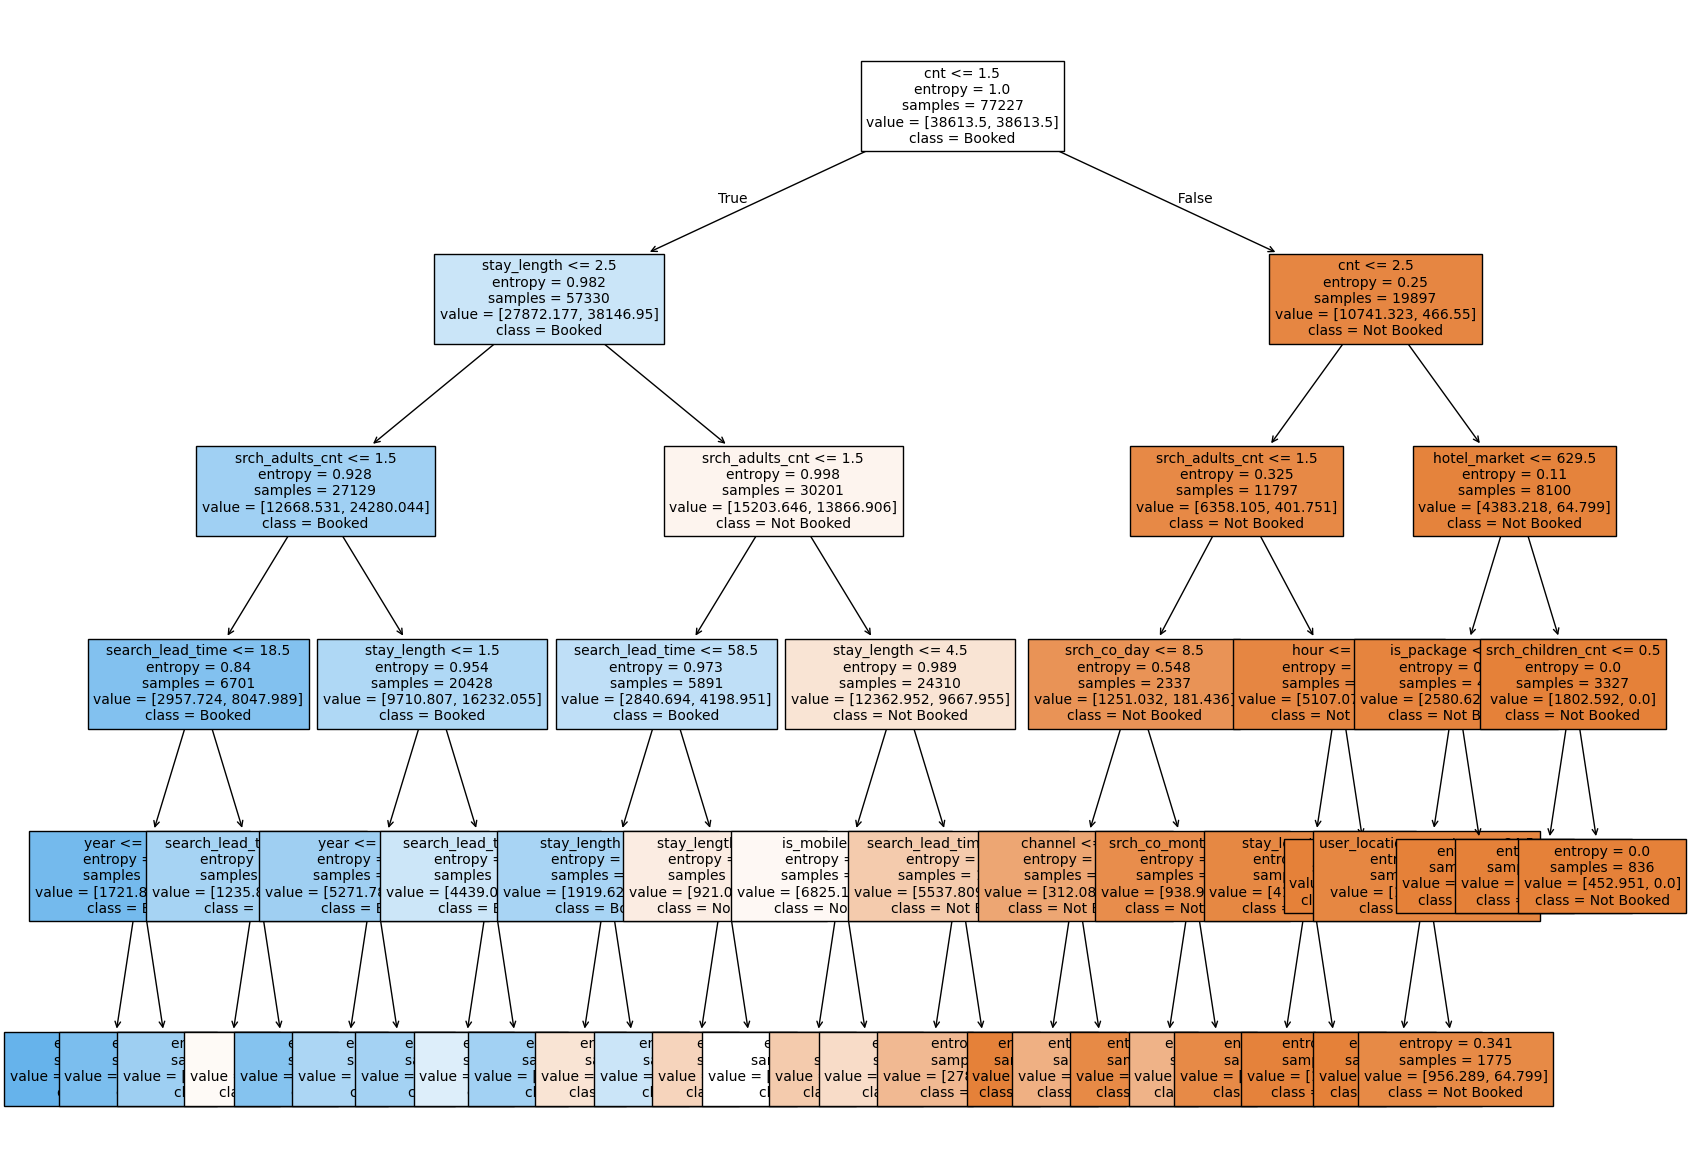

In [ ]:
# Obtain the Best Model
best_model = clf.best_estimator_

# Visualize the Decision Tree
plt.figure(figsize=(20, 15))
plot_tree(best_model, feature_names = list(X.columns), fontsize=10, filled = True, class_names = ['Not Booked', 'Booked'])

The question here is: which model is better? What do we compare? We compare the performance of the selected metric for our models. The one in the DT is better, so that's the one we'll select. And that's the one we'll use to test.

## Plot a better Decision Tree

In [ ]:
# Make Predictions on Test Set
y_pred = best_model.predict(X_test)

# Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Confusion Matrix (numeric)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy: 0.50
Precision: 0.12
Recall: 0.86
Confusion Matrix:
[[8354 9492]
 [ 211 1250]]
